# **[1] Install Libraries & Import Dependencies**

In [1]:
# Install the necessary Google Cloud libraries
%pip install --upgrade google-cloud-bigquery google-cloud-language -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Import basic libraries
import re
import pandas as pd
import numpy as np
import logging
from wordcloud import WordCloud

# Import libraries for sentiment analysis with VADER
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Import libraries for reviews theme extraction using TF-IDF & KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from umap import UMAP

# Import libraries for GCP services
from google.cloud import bigquery

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# --- Configuration ---
PROJECT_ID = "my-secret-project-id"
LOCATION = "us-central1"

SOURCE_TABLE = f"{PROJECT_ID}.yelp_golden.reviews_for_batch_prediction_rnf"
DESTINATION_TABLE = f"{PROJECT_ID}.yelp_golden.downstream_snr_results"

TEXT_COL         = "text"       # col name in df_reviews
ID_COL           = "review_id"  # col name in df_reviews
N_CLUSTERS       = 6            # try 5–8 for retail

# Auto-choose best k via silhouette (quick, small search):
AUTO_CHOOSE_K = False
K_CANDIDATES  = [5, 6, 7, 8]

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# **[2] Initialize GCP Client**

In [3]:
# Initialize BigQuery Client
bq_client = bigquery.Client(project=PROJECT_ID)

logging.info(f"Clients initialized for project '{PROJECT_ID}' in location '{LOCATION}'.")

# **[3] Fetch Data from Bigquery**

In [8]:
# Process reviews for Shopping & Retail business category only
query = f"""
    SELECT r.review_id, r.text
    FROM `{SOURCE_TABLE}` r
    LEFT JOIN `{DESTINATION_TABLE}` d ON r.review_id = d.review_id
    WHERE r.text IS NOT NULL AND general_category = 'Shopping & Retail'
"""

print(f"Fetching data from BigQuery...")
df = bq_client.query(query).to_dataframe()
print(f"Successfully fetched {len(df)} reviews into a pandas DataFrame.")

Fetching data from BigQuery...
Successfully fetched 14697 reviews into a pandas DataFrame.


In [9]:
df.head()

,review_id,text
0,bRPcg5NxYzIsz7cn9ZyN_Q,On my first visit to New Orleans I visited thi...
1,Mtd_lzIMBoTcEld-yh7OzQ,Stopped by today to pick up color changing bat...
2,CcpLnyqI07MEKYys0mq2HA,I purchased two chairs which they were holding...
3,mW8ZDyQ57SIwbYN--li24A,My wife and I have been coming to Zionsville E...
4,r3KUHaMQl-6qLNTeRdW2fg,I have used Amy's Flowers for over ten years a...


# **[4] Text Cleansing**

In [10]:
_url_re   = re.compile(r'https?://\S+|www\.\S+')
_mention  = re.compile(r'@\w+')
_html     = re.compile(r'<.*?>')
_multi_ws = re.compile(r'\s+')
_non_eng  = re.compile(r'[^a-zA-Z0-9\s\.\,\!\?\']')  # keep basic punctuation
_dup_punc = re.compile(r'([!?.,])\1+')

def clean_text(t: str) -> str:
    if not isinstance(t, str):
        return ""
    t = t.strip()
    t = _url_re.sub(' ', t)
    t = _mention.sub(' ', t)
    t = _html.sub(' ', t)
    t = t.replace('\n', ' ')
    t = _dup_punc.sub(r'\1', t)
    t = _non_eng.sub(' ', t)
    t = t.lower()
    t = _multi_ws.sub(' ', t).strip()
    return t

# Apply cleaning
df["clean_text"] = df[TEXT_COL].apply(clean_text)
df = df[df["clean_text"].str.len() > 0].reset_index(drop=True)

print(f"Rows after cleaning: {len(df):,}")

Rows after cleaning: 14,697


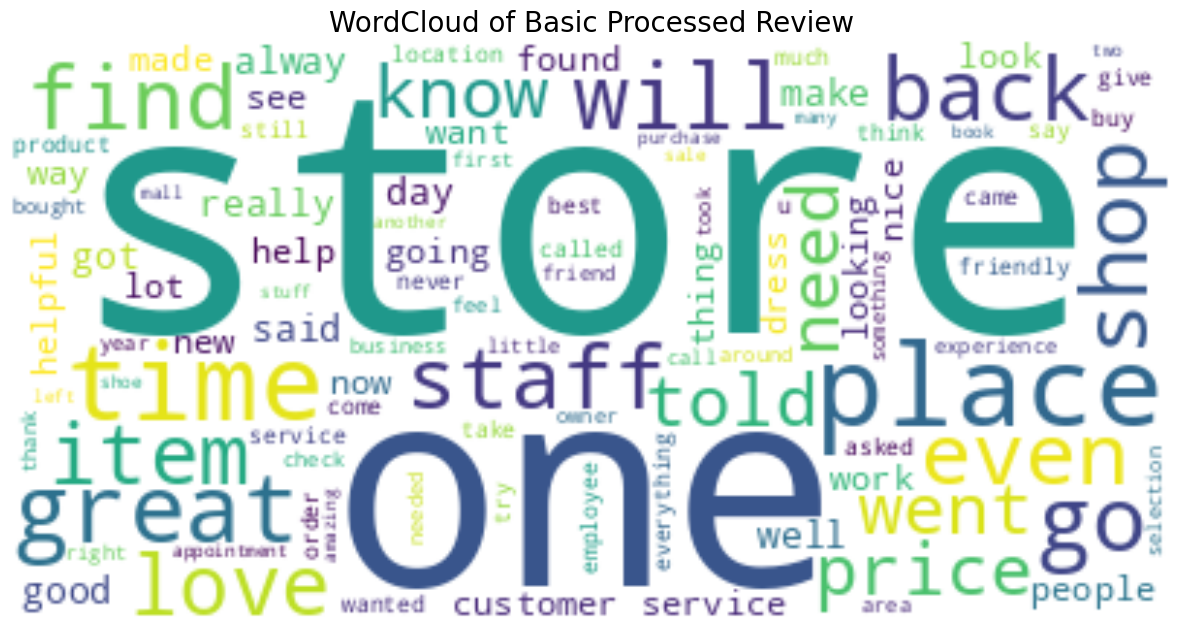

In [14]:
# Word cloud of processed tweets
processed_s1 = ' '.join(df["clean_text"].tolist())
word_cloud_1 = WordCloud(max_words=100, random_state=100, background_color="white").generate(processed_s1)

plt.figure(figsize=(15, 10))
plt.imshow(word_cloud_1, interpolation='bilinear')
plt.title('WordCloud of Basic Processed Review', fontsize=20)
plt.axis("off")
plt.show()

# **[5] Sentiment Analysis with VADER: Task 1, 2**

Task 1 is detecting review sentiment, while Task 2 is knowing the sentiment score

In [24]:
# Initialize the VADER sentiment analysis
vader_analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    scores = vader_analyzer.polarity_scores(text)
    compound_score = scores['compound']
    if compound_score >= 0.05:
        return "Positive", compound_score
    elif compound_score <= -0.05:
        return "Negative", compound_score
    else:
        return "Neutral", compound_score

In [27]:
# Apply the function to the 'clean_text' column
df[['sentiment', 'sentiment_score']] = df['clean_text'].apply(lambda x: pd.Series(get_vader_sentiment(x)))

logging.info(f"VADER sentiment analysis complete.")
df.head()

,review_id,text,clean_text,sentiment_score,sentiment
0,bRPcg5NxYzIsz7cn9ZyN_Q,On my first visit to New Orleans I visited thi...,on my first visit to new orleans i visited thi...,0.9041,Positive
1,Mtd_lzIMBoTcEld-yh7OzQ,Stopped by today to pick up color changing bat...,stopped by today to pick up color changing bat...,0.9987,Positive
2,CcpLnyqI07MEKYys0mq2HA,I purchased two chairs which they were holding...,i purchased two chairs which they were holding...,-0.8516,Negative
3,mW8ZDyQ57SIwbYN--li24A,My wife and I have been coming to Zionsville E...,my wife and i have been coming to zionsville e...,0.9801,Positive
4,r3KUHaMQl-6qLNTeRdW2fg,I have used Amy's Flowers for over ten years a...,i have used amy's flowers for over ten years a...,0.9354,Positive


In [29]:
# Check sentiment distribution
df['sentiment'].value_counts()

sentiment
Positive    11831
Negative     2661
Neutral       205
Name: count, dtype: int64

# **[6] Topic Modeling with TF-IDF & KMeans: Task 3**

Basically, Task 3 is to extract the review theme using the simplest method

In [30]:
# Vectorize cleaned text
vec = TfidfVectorizer(
    max_df=0.9,            # ignore too-common terms
    min_df=10,             # ignore very rare terms
    stop_words="english",
    ngram_range=(1, 2),
)
X = vec.fit_transform(df["clean_text"].values)

def choose_k_by_silhouette(X, k_candidates):
    best_k, best_score = None, -1
    for k in k_candidates:
        km = KMeans(n_clusters=k, n_init="auto", random_state=42)
        labels = km.fit_predict(X)
        if X.shape[0] > 5000:
            idx = np.random.choice(X.shape[0], size=5000, replace=False)
            score = silhouette_score(X[idx], labels[idx])
        else:
            score = silhouette_score(X, labels)
        if score > best_score:
            best_k, best_score = k, score
    return best_k, best_score

if AUTO_CHOOSE_K:
    N_CLUSTERS, _ = choose_k_by_silhouette(X, K_CANDIDATES)
    print(f"Auto-selected N_CLUSTERS = {N_CLUSTERS}")

kmeans = KMeans(n_clusters=N_CLUSTERS, n_init="auto", random_state=42)
df["cluster_id"] = kmeans.fit_predict(X)

# Extract top terms per cluster
def top_terms_per_cluster(kmeans, vectorizer, top_n=10):
    centroids = kmeans.cluster_centers_
    terms = np.array(vectorizer.get_feature_names_out())
    top_terms = {}
    for i in range(centroids.shape[0]):
        idx = np.argsort(centroids[i])[::-1][:top_n]
        top_terms[i] = terms[idx].tolist()
    return top_terms

cluster_terms = top_terms_per_cluster(kmeans, vec, top_n=8)
# Attach cluster top words as a string for easy use
df["cluster_top_terms"] = df["cluster_id"].map(lambda c: ", ".join(cluster_terms.get(c, [])))

In [32]:
df.head()

,review_id,text,clean_text,sentiment_score,sentiment,cluster_id,cluster_top_terms
0,bRPcg5NxYzIsz7cn9ZyN_Q,On my first visit to New Orleans I visited thi...,on my first visit to new orleans i visited thi...,0.9041,Positive,2,"dress, told, said, time, just, store, went, didn"
1,Mtd_lzIMBoTcEld-yh7OzQ,Stopped by today to pick up color changing bat...,stopped by today to pick up color changing bat...,0.9987,Positive,5,"love, place, great, love place, store, love st..."
2,CcpLnyqI07MEKYys0mq2HA,I purchased two chairs which they were holding...,i purchased two chairs which they were holding...,-0.8516,Negative,2,"dress, told, said, time, just, store, went, didn"
3,mW8ZDyQ57SIwbYN--li24A,My wife and I have been coming to Zionsville E...,my wife and i have been coming to zionsville e...,0.9801,Positive,4,"hair, great, recommend, staff, friendly, highl..."
4,r3KUHaMQl-6qLNTeRdW2fg,I have used Amy's Flowers for over ten years a...,i have used amy's flowers for over ten years a...,0.9354,Positive,2,"dress, told, said, time, just, store, went, didn"


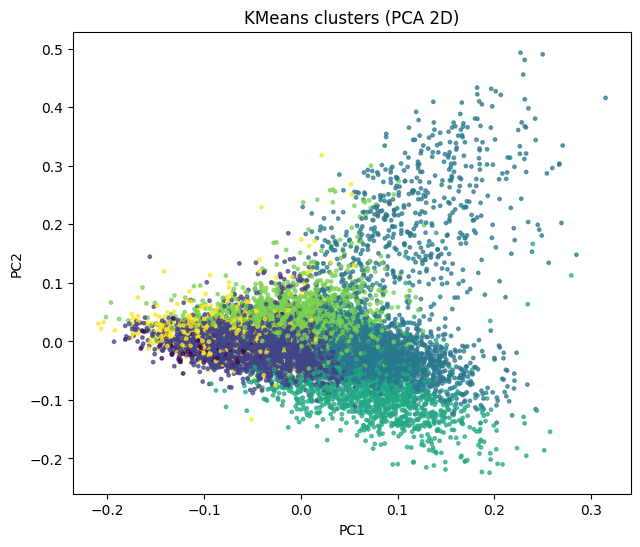

In [34]:
# Quick 2D visualization of clusters
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X.toarray() if hasattr(X, "toarray") and X.shape[0] <= 15000 else X[:15000].toarray())
plot_df = df.iloc[:coords.shape[0]].copy()
plot_df["pc1"], plot_df["pc2"] = coords[:, 0], coords[:, 1]

plt.figure(figsize=(7.2, 6.0))
plt.scatter(plot_df["pc1"], plot_df["pc2"], s=6, c=plot_df["cluster_id"], alpha=0.7)
plt.title("KMeans clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


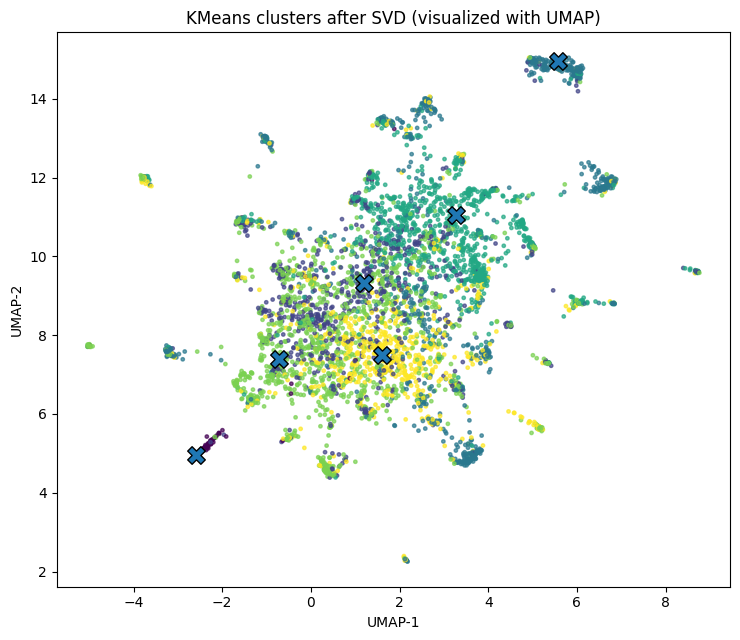

In [36]:
# Dimensionality reduction BEFORE clustering (denoise + speed) wth 100–200 comps
svd = TruncatedSVD(n_components=150, random_state=42)
X_svd = svd.fit_transform(X)
X_svd = Normalizer(copy=False).fit_transform(X_svd)  # scale for KMeans

# KMeans on SVD space
N_CLUSTERS = 6
kmeans = KMeans(n_clusters=N_CLUSTERS, n_init="auto", random_state=42)
labels = kmeans.fit_predict(X_svd)

# Get readable top terms per cluster by approx inverse-transform
def top_terms_from_svd_centroids(kmeans, svd, vectorizer, top_n=10):
    # Project centroids back into TF-IDF space for term ranking
    centroids_tfidf = svd.inverse_transform(kmeans.cluster_centers_)  # shape: (k, n_terms)
    terms = vectorizer.get_feature_names_out()
    top = {}
    for i, row in enumerate(centroids_tfidf):
        idx = np.argsort(row)[::-1][:top_n]
        top[i] = terms[idx].tolist()
    return top

cluster_terms = top_terms_from_svd_centroids(kmeans, svd, vec, top_n=8)

# UMAP for visualization (on SVD space)
max_points = 5000
if X_svd.shape[0] > max_points:
    sample_idx = np.random.choice(X_svd.shape[0], size=max_points, replace=False)
else:
    sample_idx = np.arange(X_svd.shape[0])

X_svd_sample = X_svd[sample_idx]
labels_sample = labels[sample_idx]

umap_model = UMAP(
    n_neighbors=15,      # try 15–50 for different granularity
    min_dist=0.1,        # lower = tighter clusters
    n_components=2,
    metric="cosine",
    random_state=42
)
X_2d = umap_model.fit_transform(X_svd_sample)

# Project cluster centroids into 2D (UMAP supports transform)
centroids_2d = umap_model.transform(kmeans.cluster_centers_)

# Plot
plt.figure(figsize=(7.5, 6.5))
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=6, alpha=0.7, c=labels_sample)
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], s=160, marker="X", edgecolor="k")
plt.title("KMeans clusters after SVD (visualized with UMAP)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()

In [37]:
print(df["cluster_id"].value_counts())
print(df["cluster_top_terms"].value_counts())

cluster_id
1    6455
2    3338
4    2331
3    1256
5    1023
0     294
Name: count, dtype: int64
cluster_top_terms
store, place, great, good, like, selection, shop, items                          6455
dress, told, said, time, just, store, went, didn                                 3338
hair, great, recommend, staff, friendly, highly, experience, highly recommend    2331
customer, customer service, service, store, great, great customer, time, just    1256
love, place, great, love place, store, love store, staff, friendly               1023
mall, stores, food, court, food court, shopping, malls, like                      294
Name: count, dtype: int64


In [39]:
# give short label theme name

def giving_theme_name(terms):
    if terms == "store, place, great, good, like, selection, shop, items":
        return "Product Variety & Selection"
    elif terms == "dress, told, said, time, just, store, went, didn":
        return "Clothing & Apparel Experience"
    elif terms == "hair, great, recommend, staff, friendly, highly, experience, highly recommend":
        return "Hair & Beauty Services"
    elif terms == "customer, customer service, service, store, great, great customer, time, just":
        return "Customer Service Quality"
    elif terms == "love, place, great, love place, store, love store, staff, friendly":
        return "Staff Friendliness & Atmosphere"
    else:
        return "Mall & Food Court Experience"
    
# Apply the function to the 'cluster_top_terms' column
df[['review_theme']] = df['cluster_top_terms'].apply(lambda x: pd.Series(giving_theme_name(x)))

logging.info(f"Giving theme name complete.")
df.head()

,review_id,text,clean_text,sentiment_score,sentiment,cluster_id,cluster_top_terms,review_theme
0,bRPcg5NxYzIsz7cn9ZyN_Q,On my first visit to New Orleans I visited thi...,on my first visit to new orleans i visited thi...,0.9041,Positive,2,"dress, told, said, time, just, store, went, didn",Clothing & Apparel Experience
1,Mtd_lzIMBoTcEld-yh7OzQ,Stopped by today to pick up color changing bat...,stopped by today to pick up color changing bat...,0.9987,Positive,5,"love, place, great, love place, store, love st...",Staff Friendliness & Atmosphere
2,CcpLnyqI07MEKYys0mq2HA,I purchased two chairs which they were holding...,i purchased two chairs which they were holding...,-0.8516,Negative,2,"dress, told, said, time, just, store, went, didn",Clothing & Apparel Experience
3,mW8ZDyQ57SIwbYN--li24A,My wife and I have been coming to Zionsville E...,my wife and i have been coming to zionsville e...,0.9801,Positive,4,"hair, great, recommend, staff, friendly, highl...",Hair & Beauty Services
4,r3KUHaMQl-6qLNTeRdW2fg,I have used Amy's Flowers for over ten years a...,i have used amy's flowers for over ten years a...,0.9354,Positive,2,"dress, told, said, time, just, store, went, didn",Clothing & Apparel Experience


# **[LAST] Writing back to Bigquery**

In [41]:
df.columns

Index(['review_id', 'text', 'clean_text', 'sentiment_score', 'sentiment',
       'cluster_id', 'cluster_top_terms', 'review_theme'],
      dtype='object')

In [42]:
# Select and reorder columns for clarity
final_df = df[['review_id', 'sentiment', 'sentiment_score',
              'cluster_top_terms', 'review_theme']]
logging.info(f"Consolidation complete. Writing {len(final_df)} rows to BigQuery table: {DESTINATION_TABLE}")

# Write the final DataFrame to BigQuery
final_df.to_gbq(
    destination_table=DESTINATION_TABLE.replace(f"{PROJECT_ID}.", ""), # to_gbq needs dataset.table format
    project_id=PROJECT_ID,
    if_exists='replace' # Use 'replace' for the first run, 'append' if running in chunks
)

logging.info("✅ Workflow complete! All data has been processed and saved to BigQuery.")

/var/tmp/ipykernel_15089/4199076249.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  final_df.to_gbq(
100%|██████████| 1/1 [00:00<00:00, 7281.78it/s]
